# Tutorial for training a nest detection model

### Install Comet ML

In [3]:
!pip install comet_ml

  Using cached comet_ml-3.44.4-py3-none-any.whl.metadata (3.9 kB)
  Using cached everett-3.1.0-py2.py3-none-any.whl.metadata (17 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached sentry_sdk-2.13.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached wurlitzer-3.1.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached configobj-5.0.8-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached comet_ml-3.44.4-py3-none-any.whl (684 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.3/980.3 kB 20.4 MB/s eta 0:00:00
Using cached everett-3.1.0-py2.py3-none-any.whl (35 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.9 MB/s eta 0:00:00
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
Using cached sentry_sdk-2.13.0-py2.py3-none-any

### Install DeepForest library

In [4]:
# !git clone https://github.com/weecology/DeepForest.git

In [5]:
# %cd DeepForest
# !pip install -e .
# %cd ..

In [ ]:
! pip install --upgrade deepforest

In [6]:
import os
import sys

# deepforest_path = os.path.abspath("DeepForest")
# deepforest_path

In [7]:
# if deepforest_path not in sys.path:
#     sys.path.insert(0, deepforest_path)

In [1]:
# load the modules
import comet_ml
import os
import time
import numpy as np
import pandas as pd
import torch
from deepforest import main
from deepforest import get_data
from deepforest import utilities
from deepforest import preprocess
from tqdm import tqdm
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers import WandbLogger
import zipfile
import matplotlib.pyplot as plt
import subprocess

### Set up Environment Variables

#### In Google Colab
Use Colab's secret storage to securely store your API key.

1. Locate the `Secrets` tab on the left-hand side panel in your Colab notebook.
2. Add a new secret with the key name as `COMET_API_KEY` and paste your Comet ML API key as the value.

#### Locally
Set an environment variable `COMET_API_KEY` in your operating system.

##### Windows
1. Open Command Prompt and set the environment variable:

    ```bash
    setx COMET_API_KEY "your_comet_api_key"
    ```

2. Restart your terminal or IDE.

##### macOS/Linux
1. Open your terminal and add the following line to your `.bashrc`, `.zshrc`, or `.profile` file:

    ```bash
    export COMET_API_KEY="your_comet_api_key"
    ```

2. Save the file and reload the shell configuration:

    ```bash
    source ~/.bashrc  # or ~/.zshrc, ~/.profile, etc.
    ```

In [15]:
PLATFORM = "local"  # Platform can be colab or local
environment = {}
if PLATFORM == "colab":
    from google.colab import userdata

    environment["api_key"] = userdata.get("COMET_API_KEY")
else:
    environment["comet_api_key"] = os.getenv("COMET_API_KEY")

In [36]:
api_key = environment["comet_api_key"]

In [28]:
# change the project_name
comet_logger = CometLogger(project_name="temporary2", api_key="bVOa3vnaXoP7OIstSDdblokzb")
# wandb_logger = WandbLogger(api_key="4f03e312b6b363b3645ac77866294f00cf55b747")
wandb_logger = WandbLogger()

CometLogger will be initialized in online mode



### Download the Bird nest dataset

In [24]:
root_folder = "/content" if PLATFORM == "colab" else os.environ.get("cc")

root_folder = "nest_images"

def download_dataset(output_filename='Dataset.zip', extract_folder_name="dataset"):
    """
    Download a file from a URL using 'wget', extract its contents to a specified folder,
    and handle platform-specific root folder locations.

    Args:
    - output_filename (str): Name of the downloaded file.
    - extract_folder_name (str): Name of the folder to extract the contents into.

    Raises:
    - FileNotFoundError: If the downloaded zip file does not exist.

    Returns:
    None
    """
    url = 'https://www.dropbox.com/s/iczokehl2c5hcjx/nest_images.zip?dl=0'

    # Download the file using wget
    # result = subprocess.run(['wget', '-O', output_filename, url], capture_output=True, text=True)
    # 
    # # Check if the download was successful
    # if result.returncode == 0:
    #   print('Download complete.')
    # else:
    #   print('Error occurred:', result.stderr)

    # Determine the root folder based on the platform

    # FIXME this is bad codestyle, that 'root_folder' is a global variable and not passed as an argument. Especially bad is that first a download takes place for minutes...
    # Paths for zip file and extraction folder
    zip_file = os.path.join(root_folder, output_filename)
    extract_folder = os.path.join(root_folder, extract_folder_name)

    # Check if the zip file exists
    if not os.path.exists(zip_file):
        raise FileNotFoundError(f"The zip file {zip_file} does not exist.")

    # Create the extract folder if it doesn't exist
    os.makedirs(extract_folder, exist_ok=True)

    # Open the zip file and extract its contents
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        for file in tqdm(zip_ref.namelist(), desc="Extracting", unit="files"):
            zip_ref.extract(file, extract_folder)

    print(f"Successfully unzipped {zip_file} to {extract_folder}.")
    return extract_folder




In [10]:
extract_folder=download_dataset()
print(extract_folder)

NameError: name 'download_dataset' is not defined

In [4]:
extract_folder = "/home/christian/hnee/DeepForest/docs/examples/nest_images/dataset"

In [5]:
# Check if the annotations file has been extracted from the zip file
annotations = pd.read_csv(os.path.join(extract_folder, "nest_data.csv"))
try:
    annotations.drop(["annotator"], inplace=True, axis=1)
except KeyError:
    pass
columns_to_convert = ['xmin', 'ymin', 'xmax', 'ymax']

annotations[columns_to_convert] = annotations[columns_to_convert].astype(int)

annotations.head()

annotations.to_csv(os.path.join(extract_folder, "nest_data.csv"), index=False)

In [6]:
# Gather all the images ending with .JPG
image_names = [file for file in os.listdir(extract_folder) if file.endswith(".JPG")]

In [7]:
# Generate crops of the image which has Region of Interest (ROI)

#FIXME this is a stupid demo because this cropping takes more than 20 minutes and given the images overlap a lot it is a waste of time

crop_dir = os.path.join(os.getcwd(), "train_data_folder")
annotation_path = os.path.join(extract_folder, "nest_data.csv")

df_annotations = pd.read_csv(annotation_path)
try:
    df_annotations.drop(["annotator"], inplace=True, axis=1)
except KeyError:
    pass    

df_annotations.to_csv(annotation_path, index=False)

all_annotations = []
image_names = image_names[:300] ## TODO DEBUGGING THIS SHIT

# image_names = ["Horus_04_27_2022_DJI_0207.JPG"]

# for image in image_names:
#     image_path = os.path.join(extract_folder, image)
#     annotations = preprocess.split_raster(
#         path_to_raster=image_path,
#         annotations_file=annotation_path,
#         patch_size=400,
#         patch_overlap=0.05,
#         base_dir=crop_dir,
#     )
#     all_annotations.append(annotations)
# train_annotations = pd.concat(all_annotations, ignore_index=True)

KeyboardInterrupt: 

In [8]:
train_annotations

NameError: name 'train_annotations' is not defined

In [9]:
image_paths = train_annotations.image_path.unique()

## FIXME: this split and the overlap above creates data leaakage
## IF the test comes from val there is a data leakage too

# split into 70% train, 20% validation and 10% test annotations
temp_paths = np.random.choice(image_paths, int(len(image_paths) * 0.30))
valid_paths = np.random.choice(temp_paths, int(len(image_paths) * 0.20))
test_paths = [path for path in temp_paths if path not in valid_paths]

valid_annotations = train_annotations.loc[
    train_annotations.image_path.isin(valid_paths)
]
test_annotations = train_annotations.loc[train_annotations.image_path.isin(test_paths)]
train_annotations = train_annotations.loc[
    ~train_annotations.image_path.isin(temp_paths)
]

NameError: name 'train_annotations' is not defined

In [10]:
len(image_paths)

NameError: name 'image_paths' is not defined

In [11]:
# View output

#print("There are {} training crown annotations".format(train_annotations.shape[0]))
#print("There are {} test crown annotations".format(valid_annotations.shape[0]))

crop_dir = os.path.join(os.getcwd(), "train_data_folder")
annotation_path = os.path.join(extract_folder, "nest_data.csv")

# save to file and create the file dir
annotations_file = os.path.join(crop_dir, "train.csv")
validation_file = os.path.join(crop_dir, "valid.csv")
test_file = os.path.join(crop_dir, "test.csv")

# train_annotations.drop(["annotator"], inplace=True, axis=1)
# valid_annotations.drop(["annotator"], inplace=True, axis=1  )
# test_annotations.drop(["annotator"], inplace=True, axis=1  )

# print(train_annotations.head())

# # Write window annotations file without a header row, same location as the "base_dir" above.
#train_annotations.to_csv(annotations_file, index=False)
#valid_annotations.to_csv(validation_file, index=False)
#test_annotations.to_csv(test_file, index=False)


In [12]:
validation_file

'/home/christian/hnee/DeepForest/docs/examples/train_data_folder/valid.csv'

In [13]:
annotations_file

'/home/christian/hnee/DeepForest/docs/examples/train_data_folder/train.csv'

In [29]:
# initialize the model and change the corresponding config file
m = main.deepforest(label_dict={"Nest": 0})
# m = main.deepforest()

m.config["batch_size"] = 20

# move to GPU and use all the GPU resources
m.config["gpus"] = "-1"
m.config["train"]["csv_file"] = annotations_file
m.config["train"]["root_dir"] = os.path.dirname(annotations_file)

# Define the learning scheduler type
# m.config["train"]["scheduler"]["type"] = "cosine"
m.config["score_thresh"] = 0.4
m.config["train"]["epochs"] = 20
m.config["validation"]["csv_file"] = validation_file
m.config["validation"]["root_dir"] = os.path.dirname(validation_file)

Reading config file: /home/christian/hnee/DeepForest/deepforest/data/deepforest_config.yml


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [30]:
validation_file

'/home/christian/hnee/DeepForest/docs/examples/train_data_folder/valid.csv'

In [31]:
annotations_file

'/home/christian/hnee/DeepForest/docs/examples/train_data_folder/train.csv'

In [32]:
# m.config["train"]["scheduler"]["type"]

In [33]:
# create a pytorch lighting trainer used to training
# m.create_trainer(logger=wandb_logger)
m.create_trainer(logger=comet_logger)
# m.create_trainer()
# load the lastest release model (RetinaNet)
m.use_release()

# TODO check if this works
m.use_bird_release(check_release=True)


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Model saved to: /home/christian/hnee/DeepForest/deepforest/data/NEON.pt
Loading pre-built model: main


In [34]:
# Start the training
start_time = time.time()
m.trainer.fit(m)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/karisu/temporary2/6bda25136f8d4fce813c5254ab698322

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | model      | RetinaNet             | 32.1 M | train
1 | iou_metric | IntersectionOverUnion | 0      | train
2 | mAP_metric | MeanAveragePrecision  | 0      | train
-------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
204       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : fuchsia_contract_8202
COMET INFO:     url                   : https://www.comet.com/karisu/temporary2/6bda25136f8d4fce813c5254ab698322
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Nest_Precision                   : 1.0
COMET INFO:     Nest_Recall                      : 1.0
COMET INFO:     box_precision                    : 0.7099090814590454
COMET INFO:     box_recall                       : 0.9411691427230835
COMET INFO:     iou [20]                         : (0.7393167018890381, 0.7749800682067871)
COMET INFO:     iou/cl_0 [20]                    : (0.7393168210983276, 0.7749797701835632)

--- Training on GPU: 3170.66 seconds ---


In [35]:
# save the prediction result to a prediction folder
save_dir = os.path.join(os.getcwd(), "pred_result_test")
results = m.evaluate(
    test_file, os.path.dirname(test_file), iou_threshold=0.4, savedir=save_dir
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/karisu/temporary2/6bda25136f8d4fce813c5254ab698322

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Deep_Forest_Birds
COMET INFO:     url                   : https://www.comet.com/karisu/temporary2/6bda25136f8d4fce813c5254ab698322
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     config_args               : None
COMET INFO:     config_file               : deepforest_config.yml
COMET INFO:     existing_train_dataloader : None
COMET INFO:     existing_val_dataloader   : None
COMET INFO:     label_dict/Nest           : 0
COMET INFO:     model                     : None
COMET INFO:     num_classes               : 1
COMET INFO:     transforms                : None
COMET INFO:   Uploa

In [36]:
results["box_precision"]

0.7674635970090515

In [37]:
results["box_recall"]

0.9646776406035665

In [38]:
# save the results to a csv file
results["results"].to_csv("results_test_lr_cosine.csv", index=False)

In [40]:
# Save the model checkpoint
m.trainer.save_checkpoint(
    os.path.join("models", "checkpoint_epochs_10_cosine_lr_retinanet.pl")
)

In [41]:
torch.save(m.model.state_dict(), os.path.join("models", "weights_cosine_lr"))

In [42]:
# Load from the saved checkpoint
model = main.deepforest.load_from_checkpoint(
    os.path.join("models", "checkpoint_epochs_10_cosine_lr_retinanet.pl")
)

Reading config file: /home/christian/hnee/DeepForest/deepforest/data/deepforest_config.yml


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

374 predictions in overlapping windows, applying non-max supression
241 predictions kept after non-max suppression


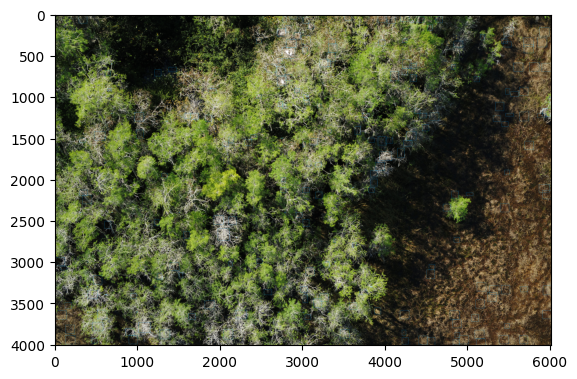

In [52]:
from pathlib import Path
# Add a path to an image to test the model on
from PIL import Image
raster_path = Path("/home/christian/hnee/DeepForest/docs/examples/nest_images/dataset/") 
image_name = "JetPortNew_03_029_2022_DJI_0437.JPG"
# image_name = "Horus_04_27_2022_DJI_0327.JPG"
# image_name = "Horus_04_27_2022_DJI_0213.JPG"
predicted_raster = model.predict_tile(
    raster_path / image_name, return_plot=True, patch_size=400, patch_overlap=0.25
)

im = Image.fromarray(predicted_raster)
im.save(f"predicted_raster_{image_name}")
plt.imshow(predicted_raster)
plt.show()